# EEG Classification using Conv-LSTM model
Here we do hyperparameter grid search by making own GridSearch object and without using library functions or objects (such as GridSearchCV from sklearn). We need to create such an object, because it is not correct to compare neural networks by scores after a fixed number of epochs (due to overfiting and so on) and we need to plot learning curves.

In [1]:
import os
import numpy as np
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Conv1D, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import Callback
from keras import backend as K
from keras.regularizers import l1_l2

from src import data as dt

/home/moskaleona/anaconda2/envs/tfcpu/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#import keras.backend as K
#K.tf.device('/gpu:0')
#K.set_session(K.tf.Session(config=K.tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)))

In [3]:
path_to_data = '../sample_data' #'/home/moskaleona/alenadir/data/rawData' #'C:/Users/alena/Desktop/homed/laba/data/rawData' 

In [4]:
data = dt.DataBuildClassifier(path_to_data).get_data([33], shuffle=True, random_state=1, resample_to=128, windows=[(0.2, 0.5)],baseline_window=(0.2, 0.3))

In [5]:
from sklearn.model_selection import train_test_split
X, y = data[33][0], data[33][1]
X_train, X_test, y_train, y_test = train_test_split(data[33][0], data[33][1], test_size=0.2, stratify=data[33][1], random_state=108)

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve
import logging

class LossMetricHistory(Callback):
    def __init__(self, n_iter, validation_data=(None,None), verbose=1, 
                 fname_bestmodel=None, fname_lastmodel=None):
        super(LossMetricHistory, self).__init__()
        self.n_iter = n_iter
        self.x_val, self.y_val = validation_data
        self.fname_best = fname_bestmodel
        self.fname_last = fname_lastmodel
        if self.x_val is not None and self.y_val is not None:
            self.validate = True
        else:
            self.validate = False
        self.verbose = verbose
        
        self.logger = logging.getLogger(self.__class__.__name__)
        self.logger.setLevel(logging.INFO)
        console = logging.StreamHandler()
        console.setLevel(logging.INFO)
        formatter = logging.Formatter("%(message)s")
        console.setFormatter(formatter)
        if len(self.logger.handlers) > 0:
            self.logger.handlers = []
        self.logger.addHandler(console)
            
    
    def on_train_begin(self, logs={}):
        if self.verbose > 0:
            self.logger.info("Training began")
        self.losses = []
        self.val_losses = []
        self.accs = [] # accuracy scores
        self.val_accs = [] # validation accuracy scores
        self.aucs = []# validation ROC AUC scores
        self.sens = []# validation sensitivity (or True Positive Rate) scores
        self.spc = [] # validation specificity scores
        self.thresholds = [] # Decreasing thresholds used to compute specificity and sensitivity
        
        self.maxauc = 0
        self.bestepoch = 0
    
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accs.append(logs.get('acc'))
        if self.validate: 
            self.val_losses.append(logs.get('val_loss'))
            self.val_accs.append(logs.get('val_acc'))
            self.y_pred = self.model.predict_proba(self.x_val, verbose=0)
            self.aucs.append(roc_auc_score(self.y_val, self.y_pred))
            
            FPR, TPR, thresholds = roc_curve(self.y_val, self.y_pred)
            self.sens.append(TPR)
            self.spc.append(1-FPR)
            self.thresholds.append(thresholds)
            
            if self.aucs[-1] > self.maxauc:
                self.maxauc = self.aucs[-1]
                self.bestepoch = epoch
                if self.fname_best is not None:
                    self.model.save(self.fname_best)
            
            if self.verbose > 0:
                self.logger.info("Epoch %d/%d: train loss = %.6f, test loss = %.6f"%(epoch+1, self.n_iter, 
                                                                    self.losses[-1],self.val_losses[-1]) + 
                                 "\n\tacc = %.6f, test acc = %.6f"%(self.accs[-1], self.val_accs[-1]) +
                                 "\n\tauc = %.6f"%(self.aucs[-1]))
        elif self.verbose > 0:
            self.logger.info("Epoch %d/%d results: train loss = %.6f"%(epoch+1, self.n_iter, self.losses[-1]) + 
                             "\n\t\t\tacc = %.6f"%(self.accs[-1]))
    def on_train_end(self, logs={}):
        self.losses = np.array(self.losses)
        if self.validate:
            self.val_losses = np.array(self.val_losses)
            self.scores = {}
            self.scores['auc'] = np.array(self.aucs)
            self.scores['acc'] = np.array(self.val_accs)
            self.scores['sens'] = np.array(self.sens)
            self.scores['spc'] = np.array(self.spc)
            self.scores['thresholds'] = np.array(self.thresholds)
        if self.fname_last is not None:
            self.model.save(self.fname_last)
        

In [13]:
import re
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin

class CnnLstmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, loss='binary_crossentropy', n_filters=10, n_lstm=30, n_iter=150,
                 batch_size=10,learning_rate=0.001, l1=0., l2=0.0, dropout=0.,
                 dropout_lstm=0., recurrent_dropout=0., threshold=0.5):
        self.loss = loss
        self.n_lstm = n_lstm
        self.n_filters = n_filters
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.l1 = l1
        self.l2 = l2
        self.dropout = dropout
        self.dropout_lstm = dropout_lstm
        self.recurrent_dropout = recurrent_dropout
        self.threshold = threshold
        
    def _make_model(self, input_shape):
        batch_input_shape = (None, input_shape[1], input_shape[2])
        self.model = Sequential()
        self.model.add(Conv1D(self.n_filters, self.kernel_size_, batch_input_shape=batch_input_shape,
                         activation='relu', kernel_regularizer=l1_l2(self.l1, self.l2)))
        self.model.add(Dropout(self.dropout))
        self.model.add(LSTM(self.n_lstm,
                       dropout=self.dropout_lstm, recurrent_dropout=self.recurrent_dropout))
        self.model.add(Dense(1, activation='sigmoid'))
        
    def _plot_loss(self,fname=None):
        plt.title('Learning curves')
        plt.xlabel('epoch')
        plt.plot(np.arange(1, len(self.log_.losses)+1),self.log_.losses, color='tab:blue', label='train loss')
        plt.plot(np.arange(1, len(self.log_.val_losses)+1),self.log_.val_losses, color='tab:orange', label='test loss')
        plt.legend()
        if fname is not None:
            plt.savefig(fname)
            plt.clf()
            plt.cla()
        else:
            plt.show()
    
    def _plot_scores(self,scoring,fname=None):
        plt.title('Validation '+scoring)
        plt.xlabel('epoch')
        plt.ylabel(scoring)
        plt.plot(np.arange(1, len(self.log_.aucs)+1),self.log_.aucs, color='b')
        if fname is not None:
            plt.savefig(fname)
            plt.clf()
            plt.cla()
        else:
            plt.show()
    
    def fit(self, X_train, y_train, X_val=None, y_val=None, scoring='auc',n_iter=None,
            verbose=1, plotcurves=False, fname_loss=None, fname_score=None,
            fname_bestmodel=None, fname_lastmodel=None):
        # TODO: check the parameters
        if verbose > 0:
            print("Training model with parameters:", self.get_params())
        if n_iter is not None:
            self.n_iter = n_iter
        
        self.kernel_size_ = X_train.shape[2]
        self._make_model(X_train.shape)
        self.optimizer_ = RMSprop(lr=self.learning_rate)
        self.model.compile(loss=self.loss, optimizer=self.optimizer_, metrics=['acc'])
        
        if X_val is not None and y_val is not None:
            self.log_ = LossMetricHistory(n_iter=self.n_iter, 
                                          validation_data=(X_val, y_val), verbose=verbose, 
                                          fname_bestmodel=fname_bestmodel, fname_lastmodel=fname_lastmodel)
            self.hist_ = self.model.fit(X_train, y_train,
                                        batch_size=self.batch_size,
                                        epochs=self.n_iter, validation_data=(X_val, y_val),
                                        verbose=0, callbacks=[self.log_])
            
            self.best_score_ = self.log_.scores[scoring].max()
            if plotcurves:
                self._plot_loss(fname_loss)
                self._plot_scores(scoring, fname_score)
        else:
            self.log_ = LossMetricHistory(n_iter=self.n_iter)
            self.hist_ = self.model.fit(X_train, y_train,
                                        batch_size=self.batch_size,
                                        epochs=self.n_iter,
                                        verbose=verbose, callbacks=[self.log_])
        self.fit_ = True
        return self
    
    def predict(self, X):
        try:
            getattr(self, "fit_")
        except AttributeError:
            raise RuntimeError("You must train classifier before predicting data!")
        
        proba = self.model.predict(X)
        return (proba > self.threshold).astype('int32')
    
    def predict_proba(self, X):
        
        try:
            getattr(self, "fit_")
        except AttributeError:
            raise RuntimeError("You must train classifier before predicting data!")
        
        return self.model.predict(X)
    
    
    def score(self, X, y, scoring='auc'):
        try:
            if scoring=='auc':
                return roc_auc_score(y, self.predict_proba(X))
            elif scoring=='acc':
                return accuracy_score(y, self.predict(X))
            else:
                raise ValueError(message="No such option: '%s'. Use 'auc' or 'acc'"%str(scoring))
        except ValueError as err:
            print(err)
            
    def set_model(self, model):
        assert \
        str(type(model))=="<class 'keras.models.Sequential'>" or\
        str(type(model))=="<type 'str'>" and re.match(r'.*[^\s]\.hdf5$', filename),\
        "Model type should be keras.models.Sequential or HDF5 file"
        if str(type(model))=="<class 'keras.models.Sequential'>": 
            self.model = model
        else:
            self.model = load_model(model)
        self.n_filters = None
        self.n_lstm = None
        self.kernel_size_ = None
        self.dropout = None
        self.dropout_lstm = None
        self.recurrent_dropout = None
        self.fit_ = True
    

### Testing that everything is working

In [ ]:
%matplotlib inline
clf = CnnLstmClassifier(n_iter=3)
clf.fit(X_train, y_train, X_val=X_test, y_val=y_test, verbose=2, plotcurves=True)

('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 3, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.0, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began


## Hyperparameter tuning

In [18]:
from sklearn.model_selection import ParameterGrid
from sklearn.base import clone
from functools import reduce

class GridSearch:
    def __init__(self, estimator, param_grid, scoring='auc',
                 cv=None, verbose=0, plot_scores=True, refit=True):
        self.estimator = estimator
        self.param_grid = param_grid
        self.scoring = scoring
        self.cv = cv
        self.verbose = verbose
        self.plot_scores = plot_scores
        self.refit = refit
    
    def _get_param_iterator(self):
        """Return ParameterGrid instance for the given param_grid"""
        return ParameterGrid(self.param_grid)
    
    def _save_results(self, path, index, fold, estimator):
        if not os.path.isdir(path):
            os.mkdir(path)
        if not os.path.isdir(os.path.join(path, index)):
            os.mkdir(os.path.join(path, index))
        
        path_to_results = os.path.join(path, index, fold)
        if not os.path.isdir(path_to_results):
            os.mkdir(path_to_results)
        
        os.rename(os.path.join(path,'tmp','loss.png'), os.path.join(path_to_results,'loss'+index+'.png'))
        os.rename(os.path.join(path,'tmp','score.png'), os.path.join(path_to_results,self.scoring+index+'.png'))
        os.rename(os.path.join(path,'tmp','model'+index+str(fold)+'.hdf5'),
                  os.path.join(path, index, 'model'+index+str(fold)+'.hdf5'))
        
        params = {self.scoring:estimator.log_.scores[self.scoring],
                'accuracy':estimator.log_.scores[self.scoring],
                'spc':estimator.log_.scores['spc'],
                'sens':estimator.log_.scores['sens'],
                'thresholds':estimator.log_.scores['thresholds']}
            
        np.savez(os.path.join(path_to_results,'scores'+index),
                **params)
    
        
    def fit(self, X_train, y_train, X_test, y_test, groups=None, scoring='auc', path_to_results=None):
        n_splits = cv.get_n_splits(X, y, groups)
        candidate_params = list(self._get_param_iterator())
        n_candidates = len(candidate_params)
        param_names = self.param_grid.keys()
        
        if self.verbose > 0:
            print("Fitting {0} folds for each of {1} candidates, totalling"
                  " {2} fits".format(n_splits, n_candidates,
                                     n_candidates * n_splits))
        if path_to_results is not None:
            saveres = True
            tmp = os.path.join(path_to_results,'tmp')
            if not os.path.isdir(tmp):
                os.mkdir(tmp)
            fname_loss = os.path.join(tmp,'loss.png')
            fname_score = os.path.join(tmp,'score.png')
            
        else:
            saveres = False
            fname_loss = None
            fname_score = None
            if not os.path.isdir('tmp'):
                os.mkdir('tmp')
            tmp = 'tmp'
        
        self.scores_ = [np.array([]), np.array([])]
        #self.cv_scores_ = []
        self.best_score_ = 0
        idparams = 0
        indices = []
        with open(os.path.join(path_to_results, 'idtopars.csv'), 'w') as idp:
            idp.write(','.join(['id']+[p for p in param_names]))
            idp.write('\n')
        
        for params in candidate_params:
            idparams += 1
            index='{0:04}'.format(idparams)
            indices.append(index)
            #self.cv_scores_.append([])
            fold = 0
            best_n_iters = np.array([])
            for train, val in cv.split(X_train, y_train, groups):
                estimator = clone(self.estimator)
                estimator.set_params(**params)
                estimator.fit(X_train[train], y_train[train], X_val=X_train[val], y_val=y_train[val],
                                scoring=self.scoring, verbose=self.verbose, plotcurves=saveres,
                                fname_loss=fname_loss, fname_score=fname_score,
                                fname_bestmodel=os.path.join(tmp,'model'+index+str(fold)+'.hdf5'))
                best_n_iters = np.append(best_n_iters, estimator.log_.bestepoch)
                #self.cv_scores_[-1].append(estimator.best_score_)
                
                if saveres:
                    self._save_results(path_to_results, index, str(fold), estimator)
                with open(os.path.join(path_to_results, 'idtopars.csv'), 'a') as idp:
                    idp.write(','.join([index]+[str(params[p]) for p in param_names]))
                    idp.write('\n')
                fold += 1
                
            # Testing the best models for each fold on the hold-out data (1)
            # and testing a new model (trained on all the train dataset) 
            # with the average best number of epochs on the hold-out data (2)
            # (1)
            preds1 = np.empty(shape=(X_test.shape[0], n_splits))
            mean_score = 0
            for fold in  range(n_splits):
                if saveres:
                    path_to_model = os.path.join(path_to_results, index, 'model'+index+str(fold)+'.hdf5')
                else:
                    path_to_model = os.path.join(tmp, index, 'model'+index+str(fold)+'.hdf5')
                estimator = clone(self.estimator) 
                estimator.set_model(load_model(path_to_model))
                estimator.set_params(**params)
                preds1[:, fold] = estimator.predict_proba(X_test)[:,0]
                
            K.clear_session()
            
            y_pred1 = preds1.mean(axis=1)
            
            # (2)
            best_n_iter = best_n_iters.mean()
            estimator = clone(self.estimator)
            estimator.set_params(**params)
            estimator.fit(X_train[train], y_train[train], X_val=X_train[val], y_val=y_train[val],
                            scoring=self.scoring, n_iter=best_n_iter, verbose=self.verbose, 
                            plotcurves=saveres,fname_loss=fname_loss, fname_score=fname_score,
                            fname_lastmodel=os.path.join(tmp,'model'+index+'_mean.hdf5'))
            y_pred2 = estimator.predict_proba(X_test)[:,0]
            try:
                if scoring=='auc':
                    score1 = roc_auc_score(y_test, y_pred1)
                    score2 = roc_auc_score(y_test, y_pred2)
                elif scoring=='acc':
                    score1 = accuracy_score(y_test, y_pred1)
                    score2 = accuracy_score(y_test, y_pred2)
                else:
                    raise ValueError(message="No such option: '%s'. Use 'auc' or 'acc'"%str(scoring))
            except ValueError as err:
                print(err)
                
            if saveres:
                # (1)
                path_to_ensemble_res = os.path.join(path_to_results, index, 'ensemble')
                if not os.isdir(path_to_ensemble_res):
                    os.path.join(path_to_ensemble_res)
                fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
                np.savez(os.path.join(path_to_ensemble_res, 'ens_tpr_fpr_thres'+index), 
                        {'tpr':tpr, 'fpr':fpr, 'thresholds':thresholds})
                plt.title('ROC curve')
                plt.xlabel('FPR')
                plt.ylabel('TPR')
                plt.plot(fpr, tpr)
                plt.savefig(os.path.join(path_to_ensemble_res, 'ROC_curve.png'))
                plt.clf()
                plt.cla()
                
                with open(os.path.join(path_to_results, 'ens_score_table.csv'), 'a') as fout:
                    fout.write(index+','+str(score1))
                    fout.write('\n')
                
                # (2)
                self._save_results(path_to_results, index, 'mean', estimator)
                                 
                fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
                np.savez(os.path.join(os.path.join(path_to_results, index, 'mean'), 
                                      'mean_tpr_fpr_thres'+index), 
                        {'tpr':tpr, 'fpr':fpr, 'thresholds':thresholds})
                plt.title('ROC curve')
                plt.xlabel('FPR')
                plt.ylabel('TPR')
                plt.plot(fpr, tpr)
                plt.savefig(os.path.join(path_to_ensemble_res, 'ROC_curve.png'))
                plt.clf()
                plt.cla()
                
                with open(os.path.join(path_to_results, 'mean_score_table.csv'), 'a') as fout:
                    fout.write(index+','+str(score2))
                    fout.write('\n')
                                
            
            self.scores_[0] = np.append(self.scores_[0], score1)
            self.scores_[1] = np.append(self.scores_[1], score2)
            
        self.best_ind_ = (self.scores_[0].argmax(), self.scores_[1].argmax())
        self.best_score_ = (self.scores_[0][self.best_ind_[0]], self.scores_[1][self.best_ind_[1]])
        self.best_params_ = (candidate_params[self.best_ind_[0]], candidate_params[self.best_ind_[1]])
        
        if saveres:
            with open(os.path.join(path_to_results, 'ens_score_table.csv'), 'w') as fout:
                ind = np.argsort(self.scores_[0])
                for i in ind[::-1]:
                    fout.write(indices[i]+','+str(self.scores_[0][i]))
                    fout.write('\n')
            with open(os.path.join(path_to_results, 'mean_score_table.csv'), 'w') as fout:
                ind = np.argsort(self.scores_[1])
                for i in ind[::-1]:
                    fout.write(indices[i]+','+str(self.scores_[1][i]))
                    fout.write('\n')
        os.rmdir(tmp)
        
            
        #self.cv_scores_ = reduce(lambda a,b: np.vstack((np.array(a),np.array(b))), self.cv_scores_)
        #self.mean_scores_ = self.cv_scores_.mean(axis=1)
        #self.best_score_ = self.cv_scores_.max()
        #self.best_mean_score_ = self.mean_scores_.max()
        #self.best_ind_ = self.mean_scores_.argmax()
        
        
        '''
        self.best_params_ = candidate_params[self.best_ind_]
        if self.refit:
            if self.verbose > 0:
            print("Grid search is almost done.\n"
                  "Best score is %.6f, best mean score is %.6f.\n"
                  "Now the best estimator is training..."%(self.best_score_, self.best_mean_score_))
            
            self.best_estimator_ = clone(self.estimator).set_params(**self.best_params_)
            self.best_estimator_.fit(X,y)
        '''
        return self
        

In [19]:
'''
param_grid = {
    'n_iter' : [100, 200, 300],
    'l1' : [0., 0.2, 0.4, 0.6],
    'l2' : [0., 0.2, 0.4, 0.6],
    'dropout' : [0., 0.2, 0.4, 0.6],
    'dropout_lstm' : [0., 0.2, 0.4, 0.6],
    'recurrent_dropout' : [0., 0.2, 0.4, 0.6],
}
'''
param_grid = {
    'n_iter' : [3, 2],
    'l1' : [0., 0.2]
}

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit
clf = CnnLstmClassifier()
cv = StratifiedShuffleSplit(n_splits=3, test_size = 0.33, random_state = 108)
gs = GridSearch(clf, param_grid, cv=cv, verbose=1)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 3, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.0, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began
Epoch 1/3: train loss = 0.671020, test loss = 0.647219
	acc = 0.606452, test acc = 0.603896
	auc = 0.603673
Epoch 2/3: train loss = 0.607723, test loss = 0.639674
	acc = 0.687097, test acc = 0.623377
	auc = 0.608999
Epoch 3/3: train loss = 0.566569, test loss = 0.655795
	acc = 0.725806, test acc = 0.649351
	auc = 0.588613


('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 3, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.0, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began
Epoch 1/3: train loss = 0.700209, test loss = 0.674531
	acc = 0.564516, test acc = 0.597403
	auc = 0.505234
Epoch 2/3: train loss = 0.630856, test loss = 0.678691
	acc = 0.651613, test acc = 0.636364
	auc = 0.504867
Epoch 3/3: train loss = 0.590245, test loss = 0.662372
	acc = 0.712903, test acc = 0.636364
	auc = 0.553719


('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 3, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.0, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began
Epoch 1/3: train loss = 0.682674, test loss = 0.669887
	acc = 0.583871, test acc = 0.610390
	auc = 0.526905
Epoch 2/3: train loss = 0.603432, test loss = 0.661727
	acc = 0.674194, test acc = 0.629870
	auc = 0.550046
Epoch 3/3: train loss = 0.578981, test loss = 0.666554
	acc = 0.690323, test acc = 0.655844
	auc = 0.536639


('Training model with parameters:', {'loss': 'binary_crossentropy', 'recurrent_dropout': 0.0, 'n_iter': 3, 'learning_rate': 0.001, 'batch_size': 10, 'n_filters': 10, 'l2': 0.0, 'n_lstm': 30, 'l1': 0.0, 'threshold': 0.5, 'dropout_lstm': 0.0, 'dropout': 0.0})


Training began


TypeError: range() integer end argument expected, got numpy.float64.

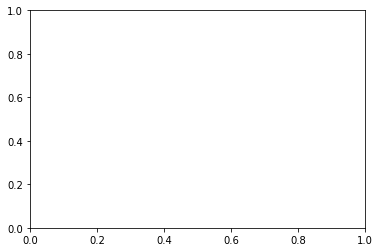

In [22]:
#%%time
gs.fit(X_train, y_train, X_test, y_test, path_to_results='results')

In [56]:
print(gs.best_estimator_)
print(gs.best_params_)
print(gs.best_score_)

CnnLstmClassifier(batch_size=10, dropout=0.0, dropout_lstm=0.0, l1=0.0,
         l2=0.0, learning_rate=0.001, loss='binary_crossentropy',
         n_filters=10, n_iter=3, n_lstm=30, recurrent_dropout=0.0,
         threshold=0.5)
{'n_iter': 3, 'l1': 0.0}
0.6474608224343114
